<a href="https://colab.research.google.com/github/AdrianKopperud/automatedfeatureengineering/blob/main/Manual_Engineering_Master_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U pandas-profiling

### Import functions

In [ ]:
# Import
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import datetime as dt
import datetime
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, TimeSeriesSplit
from time import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
import gc
import re
import xgboost as xgb
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from google.colab import drive
import math
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 3000)
pd.set_option('display.max_rows', 3000)

In [ ]:

# Function to calculate Precision and Recall

def calc_precision_recall(y_true, y_pred):
    
    # Convert predictions to series with index matching y_true
    y_pred = pd.Series(y_pred, index=y_true.index)
    
    # Instantiate counters
    TP = 0
    FP = 0
    FN = 0

    # Determine whether each prediction is TP, FP, TN, or FN
    for i in y_true.index: 
        if y_true[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_true[i]!=y_pred[i]:
           FP += 1
        if y_pred[i]==0 and test_y[i]!=y_pred[i]:
           FN += 1
    
    # Calculate true positive rate and false positive rate
    # Use try-except statements to avoid problem of dividing by 0
    try:
        precision = TP / (TP + FP)
    except:
        precision = 1
    
    try:
        recall = TP / (TP + FN)
    except:
        recall = 1

    return precision, recall

# Test function

from sklearn import metrics
def buildROC(target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.gcf().savefig('roc.png')

def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = xgb.XGBClassifier(num_boost_round=100, n_estimators = 240, tree_method='gpu_hist', )
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df


def check_missing(df):
    null_val = df.isnull().sum()
    percent = 100 * df.isnull().sum()/len(df)
    missing_table = pd.concat([null_val, percent], axis=1)
    col = missing_table.rename(columns = {0 : 'Num', 1 : 'Rate'})
    return col

def plot_missing_pct(df, features, feature_name):
    '''this function draw bar plot of missing value percentage '''
    plt.figure(figsize=(16,6))
    ax = plt.subplot(111)
    
    ax.bar(features, df[features].isnull().mean())
    ax.set_ylim(0,1)
    ax.set_xlabel(feature_name)
    ax.set_ylabel('% missing data')
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    
    plt.title('Percentage of missing values of {}'.format(feature_name))
    plt.show()

def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(24,24))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();

## Function to reduce the DF size
def memory_reducer(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    
def conf_matrix(y_test, y_predicted):
  cm = confusion_matrix(y_test, y_predicted)
  plt.figure(figsize=(15,10))
  plt.clf()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
  classNames = ['Negative','Positive']
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=45)
  plt.yticks(tick_marks, classNames)
  s = [['TN','FP'], ['FN', 'TP']]
  
  for i in range(2):
      for j in range(2):
          plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
  plt.show()

### 1 Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# IMPORT DATA
id = pd.read_csv("/content/drive/MyDrive/Thesis/Data/ID.csv")
tran = pd.read_csv("/content/drive/MyDrive/Thesis/Data/Transaction.csv")

# Remove vesta features V_xxxx
tran = tran.loc[:,~tran.columns.str.startswith('V')]

# Merge the classes 
df = pd.merge(tran, id, how="outer", on=["TransactionID"])

del tran
del id

### 2 Pre-processing

Create categories for each e-mail provider and cluster e-mail within the company provider. As such we could reduce the number of categories from 60 to a few. __Furthermore did I split up the .com, .us and so on into suffix, not sure if that may be future engineering since the data in the categorical variable are split into two different new variables.__

#### 2.1 Catagorical features

##### 2.1.1 P_emaildomain and R_emaildomain

In [ ]:
# email features: P_emaildomain, R_emaildomain
# email map
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']

# fill na
df.loc[:, ['P_emaildomain', 'R_emaildomain']] = df[['P_emaildomain', 'R_emaildomain']].fillna('None')

# clean email domains
df = df.assign(P_emaildomain_bin = df['P_emaildomain'].map(emails),
          P_emaildomain_suffix = df['P_emaildomain'].map(lambda x: str(x).split('.')[-1]).map(lambda x: 'us' if str(x) in us_emails else x),
          R_emaildomain_bin = df['R_emaildomain'].map(emails),
          R_emaildomain_suffix = df['R_emaildomain'].map(lambda x: str(x).split('.')[-1]).map(lambda x: 'us' if str(x) in us_emails else x),
        )
df.loc[:, ['P_emaildomain_bin', 'R_emaildomain_bin']] = df[['P_emaildomain_bin', 'R_emaildomain_bin']].fillna('None')

df.drop(['P_emaildomain', 'R_emaildomain'], axis=1, inplace=True)

##### 2.1.2 Device features, DeviceInfo and DeviceType

For DeviceType, DeviceInfo and other id_xx variables with device info regarding screen size, phone producer and browser, did I cluster the different brands of same name into one brand. This reduces the number of categories. Furthermore, was the NAN observations filled with None. 

In [ ]:
# deveice features: DeviceInfo, DeviceType
# device map
devices = {'SM': 'Samsung', 'SAMSUNG': 'Samsung', 'GT-': 'Samsung', 'Moto G': 'Motorola',
           'Moto': 'Motorola', 'moto': 'Motorola', 'LG-': 'LG', 'VS\d{3}': 'LG', 'LG\w{2}\d{3}': 'LG', 'rv': 'RV', 'HUAWEI': 'Huawei',
           'ALE-':'Huawei', '-L':'Huawei', 'hi6210sft': 'Huawei', 'CHC-U03': 'Huawei', 'Blade': 'ZTE', 'Z\d{3}': 'ZTE', 'BLADE': 'ZTE', 'ZTE':'ZTE', 
           'Linux': 'Linux', 'XT': 'Sony', 'F\d{4}': 'Sony', 'E\d{4}': 'Sony', 'G\d{4}': 'Sony', 'HTC': 'HTC', 'ASUS': 'Asus',
           'Pixel': 'Pixel', 'Lenovo': 'Lenovo', 'Windows': 'Windows', 'Redmi': 'Redmi', 'Ilium': 'Ilium', 'ILIUM': 'Ilium',
           'Hisense': 'Hisense', 'KF': 'Amazon', 'Android': 'Android', '\d{4}A': 'Alcatel', '\d{4}W': 'Alcatel', '\d{4}M': 'Alcatel', 
           'Alcatel': 'Alcatel', 'ALCATEL':'Alcatel', '\d{4}G': 'Mozilla', 'M4': 'M4', 'TA-': 'Nokia', 'NOKIA': 'Nokia', 'Nexus':'Nexus', 'BLU':'BLU'}

# devices_list = df.loc[:,'device_name'].value_counts().where(lambda x : x>80).dropna().index.values

devices_list = ['None', 'Windows', 'iOS Device', 'MacOS', 'Samsung', 'Trident', 'RV',
               'Motorola', 'LG', 'Huawei', 'Sony', 'ZTE', 'HTC', 'Alcatel', 'Lenovo',
               'Ilium', 'Pixel', 'Hisense', 'Amazon', 'Mozilla', 'M4', 'Redmi',
               'Nokia', 'Linux', 'Nexus', 'Android']

# clean device name
df.loc[:,'DeviceName'] = df['DeviceInfo'].str.split('/').str[0].fillna('None')
for k,v in devices.items():
    df.loc[df['DeviceName'].str.contains(k, na=False), 'DeviceName'] = v
df.loc[~df['DeviceName'].isin(devices_list), 'DeviceName'] = 'Others'

# remove DeviceInfo
df.drop(['DeviceInfo'], axis=1, inplace=True)

# DeviceType - fillna
df.loc[:,'DeviceType'] = df['DeviceType'].fillna('None')

##### 2.1.3 Other categorical features, address and card

Further I converted address and card variables from float to categorical/object as they were specified by VESTA in (https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203) to be categorical. Hence, should not be treated as numerical values as they have another meaning. Further was NAN values filled with NONE to remove the missing values and use a common new category for all missing values to keep the pattern in the data. 

In [ ]:
# other categorical features (address, card, M features)
addr_features = df.columns[df.columns.str.contains('addr')].values.tolist()
card_features = df.columns[df.columns.str.contains('card')].values.tolist()
m_features = df.columns[df.columns.str.contains('M\d+')].values.tolist()

# int to float
features_to_int = df[addr_features+card_features].dtypes.where(lambda x: x == 'float64').dropna().index
df.loc[:, features_to_int] = df.loc[:, features_to_int].astype('Int64')

# int to str
df.loc[:, addr_features+card_features] = df.loc[:, addr_features+card_features].astype(str)

# fill na
df.loc[:, addr_features+card_features+m_features] = df[addr_features+card_features+m_features].fillna('None')

# clean card type
df['card6'] = df['card6'].map(lambda x: 'None' if x not in ['debit', 'credit', 'None'] else x)

##### 2.1.4 ID_features

Clean the categorical ID_xx variables that goes from ID_12 until ID_38 + "DeviceInfo" and "DeviceType". We convert the categorical ID_xx from float to object/category as the numbers in the variables which are categorical (specified by VESTA) do not have the same numeric meaning as true numeric float variables.__Furthermore, do we split the id_01 - id_11 into its own category which we will treat accordingly in the numerical cleaning part for id_xx features!__

In [ ]:
id_features = df.columns[df.columns.str.contains('id_\d+')]
cat_id_features = ['id_'+str(x).zfill(2) for x in range(12, 38+1)]
num_id_features = ['id_'+str(x).zfill(2) for x in range(1, 12)]

In [ ]:
# missing value check
num_check_df = pd.DataFrame({'Missing Percentage': np.round(df[num_id_features].isnull().mean()*100), 
              'Zero Percentage': np.round((df[num_id_features]==0).mean()*100),
              'Total Percentage': np.round((df[num_id_features].isnull()|(df[num_id_features]==0)).mean()*100)})\
            .sort_values('Total Percentage', ascending=False)
    
cat_check_df = pd.DataFrame({'Missing Percentage': np.round(df[cat_id_features].isnull().mean()*100),
                             'Nunique': df[cat_id_features].nunique()})\
            .sort_values('Missing Percentage', ascending=False)
    
# drop missing + zero values >= 99%
num_id_features_todrop = num_check_df[num_check_df['Total Percentage'] >= 99].index.values.tolist()
num_id_features_tokeep = num_check_df[num_check_df['Total Percentage'] < 99].index.values.tolist()
df.drop(num_id_features_todrop, axis=1, inplace=True)

cat_id_features_todrop = cat_check_df[cat_check_df['Missing Percentage'] >= 99].index.values.tolist()
cat_id_features_tokeep = cat_check_df[cat_check_df['Missing Percentage'] < 99].index.values.tolist()
df.drop(cat_id_features_todrop, axis=1, inplace=True)

In [ ]:
# int to float
cat_id_features_to_int = df[cat_id_features_tokeep].dtypes.where(lambda x: x == 'float64').dropna().index
df.loc[:, cat_id_features_to_int] = df.loc[:, cat_id_features_to_int].astype('Int64')

# int to str
df.loc[:, cat_id_features_to_int] = df.loc[:, cat_id_features_to_int].astype(str)

# fill na with None
df[cat_id_features_tokeep] = df[cat_id_features_tokeep].fillna('None')

# id - system
df['sys_id_30'] = df['id_30'].str.split(' ').str[0]
sys_list = ['Windows', 'iOS', 'Mac', 'Android', 'Linux', 'None']
df['sys_id_30'] = np.where(df['sys_id_30'].isin(sys_list), df['sys_id_30'], 'None')

# id - browser
browsers = {'safari': 'safari', 'chrome': 'chrome', 'samsung': 'samsung', 'Samsung': 'samsung', 'edge': 'edge', 
 'firefox': 'firefox', 'ie':'ie', 'google':'google', 'other':'others', 'None':'None'}
browsers_list = ['chrome','safari','ie','firefox','edge','samsung','None']
for k,v in browsers.items():
    df.loc[df['id_31'].str.contains(k, na=False), 'browser_id_31'] = v
df.loc[~df['browser_id_31'].isin(browsers_list), 'browser_id_31'] = 'others'

# id - screen
df.loc[df['id_33']=='0x0', 'id_33'] = 'None'
screen_height = df.loc[df['id_33']!='None', 'id_33'].str.split('x').str[1].astype(int)
bins = [0, 900, 1500, np.inf]
screen_height_cate = pd.cut(screen_height, bins, labels=['s', 'm', 'l'])
screen_width = df.loc[df['id_33']!='None', 'id_33'].str.split('x').str[0].astype(int)
bins = [0, 1200, 2000, np.inf]
screen_width_cate = pd.cut(screen_width, bins, labels=['s', 'm', 'l'])

screen = screen_width_cate.astype(str) + 'x' + screen_height_cate.astype(str)
df.loc[df['id_33']!='None', 'screen_id_33'] = screen
df.loc[df['id_33']=='None', 'screen_id_33'] = 'None'

# drop id 30, 31, 33
df.drop(['id_30','id_31','id_33'], axis=1, inplace=True)
cat_id_features_tokeep.remove('id_30')
cat_id_features_tokeep.remove('id_31')
cat_id_features_tokeep.remove('id_33')

# Append categorical to list
cat_id_features_tokeep.extend(['sys_id_30', 'browser_id_31', 'screen_id_33'])

gc.collect()

30

##### 2.1.5 Label encoder

In [ ]:
# Label Encoding
category = []
for f in df.drop('isFraud', axis=1).columns:
    if df[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        category.append(f)
        lbl.fit(list(df[f].values))
        df[f] = lbl.transform(list(df[f].values))

#### 2.2 Numerical features

##### 2.2.1 Transaction features

AxesSubplot(0.125,0.125;0.775x0.755)


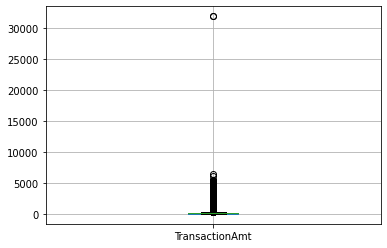

In [ ]:
# Vizualize outliers thorugh boxplot
print(df.boxplot('TransactionAmt'))

In [ ]:
df.drop(df.loc[df['TransactionAmt']>15000].index, inplace=True)

##### 2.2.2 dist features

In [ ]:
# Dist features
pd.DataFrame(np.round(df[['dist1', 'dist2']].isnull().mean()*100), columns = ['Missing Percentage'])

# drop dist 2
df.drop(['dist2'], axis=1, inplace=True)

##### 2.2.3 Remove TransactionID



In [ ]:
df.drop("TransactionID", axis=1, inplace=True)

##### 2.2.4 Impute numeric NAN

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590538 entries, 0 to 590539
Data columns (total 82 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   isFraud               590538 non-null  int64  
 1   TransactionDT         590538 non-null  int64  
 2   TransactionAmt        590538 non-null  float64
 3   ProductCD             590538 non-null  int64  
 4   card1                 590538 non-null  int64  
 5   card2                 590538 non-null  int64  
 6   card3                 590538 non-null  int64  
 7   card4                 590538 non-null  int64  
 8   card5                 590538 non-null  int64  
 9   card6                 590538 non-null  int64  
 10  addr1                 590538 non-null  int64  
 11  addr2                 590538 non-null  int64  
 12  dist1                 238267 non-null  float64
 13  C1                    590538 non-null  float64
 14  C2                    590538 non-null  float64
 15  

In [ ]:
df = df.fillna(-999)

#### Adding Date/ hour/ day/ week/ month (New features)

In [ ]:
# Engineer date and time variabels from timedelta
START_DATE = '2017-12-01'
startdate = dt.datetime.strptime(START_DATE, "%Y-%m-%d")
df["Transaction_Date"] = df['TransactionDT'].apply(lambda x: (startdate + dt.timedelta(seconds=x)))
df['Transaction_Weekdays'] = df['Transaction_Date'].dt.dayofweek
df['Transaction_Hours'] = df['Transaction_Date'].dt.hour
df['Transaction_Days'] = df['Transaction_Date'].dt.day
df['Transaction_Months'] = df['Transaction_Date'].dt.month

#### 2.3 Split Train/Test





In [ ]:
# Isolate target variable
y = df.pop('isFraud')
X = df.copy(deep=True)

In [ ]:
# train/test = 80/20

train_length = 472432
test_length = 590540

train_X, train_y = X.iloc[:train_length], y.iloc[:train_length]
test_X, test_y = X.iloc[train_length:test_length], y.iloc[train_length:test_length]

train_X, train_y = train_X.reset_index(drop=True), train_y.reset_index(drop=True)
test_X, test_y = test_X.reset_index(drop=True), test_y.reset_index(drop=True)

#### 2.4 Handmade features

##### 2.4.1 High risk/ low risk transactions (New feature)

In [ ]:
# transform transaction hours to categorical based on higest risk of fraud
train_X['TransactionHours_risk'] = np.where(train_X['Transaction_Hours'].isin([5,6,7,8,9]), 1, 0)
test_X['TransactionHours_risk'] = np.where(test_X['Transaction_Hours'].isin([5,6,7,8,9]), 1, 0)

# Remove not useful features
train_X.drop("Transaction_Date", axis=1, inplace=True)
test_X.drop("Transaction_Date", axis=1, inplace=True)

##### 2.4.2 Log transaction amount (New feature)

In [ ]:
# Log of transaction amount
train_X.loc[:, 'TransactionAmt_log'] = np.log(train_X['TransactionAmt'])
test_X.loc[:, 'TransactionAmt_log'] = np.log(test_X['TransactionAmt'])

##### 2.4.3 Decimal part of transaction amount (New feature)

In [ ]:
# New feature - decimal part of the transaction amount.
train_X['TransactionAmt_decimal'] = ((train_X['TransactionAmt'] - train_X['TransactionAmt'].astype(int)) * 1000).astype(int)
test_X['TransactionAmt_decimal'] = ((test_X['TransactionAmt'] - test_X['TransactionAmt'].astype(int)) * 1000).astype(int)

##### 2.4.4 Aggregation (New feature)


In [ ]:
from tqdm import tqdm_notebook

In [ ]:
def create_new_columns(key, aggs):
    return [key + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [ ]:
aggs = {}
for col in ['TransactionAmt']:
    aggs[col] = ['mean', 'median', 'var', 'skew', 'min', 'max']
aggs

{'TransactionAmt': ['mean', 'median', 'var', 'skew', 'min', 'max']}

In [ ]:
df_temp = pd.concat([train_X, test_X])
for key in tqdm_notebook(['card1','card2','card3','card5', 'TransactionAmt']):
    new_columns = create_new_columns(key, aggs)
    df_grouped = df_temp.groupby(key).agg(aggs)
    df_grouped.columns = new_columns
    df_grouped.reset_index(drop=False,inplace=True)
    train_X = train_X.merge(df_grouped,on=key,how='left')
    test_X = test_X.merge(df_grouped,on=key,how='left')

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
# Fill NAN from aggregation, where 1/N-1 turn out to be NAN, therefor they are filled with 0. 
# Source for help: https://stackoverflow.com/questions/57842316/pandas-calculate-variance-from-aggregation

train_X = train_X.fillna(0)
test_X = test_X.fillna(0)

gc.collect()

2627

##### 2.4.5 Count encoding for the card  features (New features)

In [ ]:
train_X['card1_count_full'] = train_X['card1'].map(pd.concat([train_X['card1'], test_X['card1']], ignore_index=True).value_counts(dropna=False))
test_X['card1_count_full'] = test_X['card1'].map(pd.concat([train_X['card1'], test_X['card1']], ignore_index=True).value_counts(dropna=False))

train_X['card2_count_full'] = train_X['card2'].map(pd.concat([train_X['card2'], test_X['card2']], ignore_index=True).value_counts(dropna=False))
test_X['card2_count_full'] = test_X['card2'].map(pd.concat([train_X['card2'], test_X['card2']], ignore_index=True).value_counts(dropna=False))

train_X['card3_count_full'] = train_X['card3'].map(pd.concat([train_X['card3'], test_X['card3']], ignore_index=True).value_counts(dropna=False))
test_X['card3_count_full'] = test_X['card3'].map(pd.concat([train_X['card3'], test_X['card3']], ignore_index=True).value_counts(dropna=False))

train_X['card4_count_full'] = train_X['card4'].map(pd.concat([train_X['card4'], test_X['card4']], ignore_index=True).value_counts(dropna=False))
test_X['card4_count_full'] = test_X['card4'].map(pd.concat([train_X['card4'], test_X['card4']], ignore_index=True).value_counts(dropna=False))

train_X['card5_count_full'] = train_X['card5'].map(pd.concat([train_X['card5'], test_X['card5']], ignore_index=True).value_counts(dropna=False))
test_X['card5_count_full'] = test_X['card5'].map(pd.concat([train_X['card5'], test_X['card5']], ignore_index=True).value_counts(dropna=False))

train_X['card6_count_full'] = train_X['card6'].map(pd.concat([train_X['card6'], test_X['card6']], ignore_index=True).value_counts(dropna=False))
test_X['card6_count_full'] = test_X['card6'].map(pd.concat([train_X['card6'], test_X['card6']], ignore_index=True).value_counts(dropna=False))

### 3 Model


#### ** PICKEL **

In [ ]:
# CLEAN DATA FOR MODELING
train_X = pd.read_pickle('/content/drive/MyDrive/Thesis/dataset/train_X_manual.pkl')
test_X = pd.read_pickle('/content/drive/MyDrive/Thesis/dataset/test_X_manual.pkl')
train_y = pd.read_pickle('/content/drive/MyDrive/Thesis/dataset/train_y_manual.pkl')
test_y = pd.read_pickle('/content/drive/MyDrive/Thesis/dataset/test_y_manual.pkl')

#### 3.1 SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

print("Before OverSampling, counts of label '1': {}".format(sum(train_y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(train_y==0)))

sm = SMOTE(random_state=42, sampling_strategy = 1)
X_train_new, y_train_new = sm.fit_sample(train_X, train_y)

X = pd.DataFrame(X_train_new)
X.columns = train_X.columns
y = pd.DataFrame(y_train_new)

print('After OverSampling, the shape of X_train_new: {}'.format(X.shape))
print('After OverSampling, the shape of y_train_new: {} \n'.format(y.shape))

Before OverSampling, counts of label '1': 16600
Before OverSampling, counts of label '0': 455832 

After OverSampling, the shape of X_train_new: (911664, 124)
After OverSampling, the shape of y_train_new: (911664, 1) 



Text(0.5, 1.0, 'Target variable count')

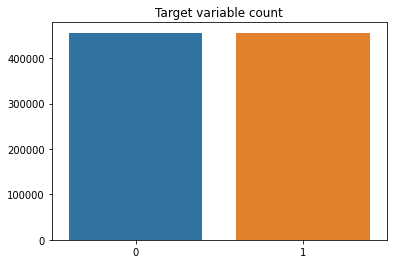

In [ ]:
x=y.value_counts().values
sns.barplot([0,1],x)
plt.title('Target variable count')

#### 3.2 XGB

In [ ]:
# Tuned most important parameters for XGB based on baseline dataset
best_params = {
 'n_estimators': 350,
 'colsample_bytree': 0.5776,
 'gamma': 0.1284,
 'learning_rate': 0.159,
 'max_depth': 17,
 'min_child_weight': 0.9205}

[0]	validation_0-auc:0.815075
Will train until validation_0-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.923671
[200]	validation_0-auc:0.925344
[300]	validation_0-auc:0.925283
[349]	validation_0-auc:0.924998


[Text(0.5, 1.0, 'Confusion Matrix')]

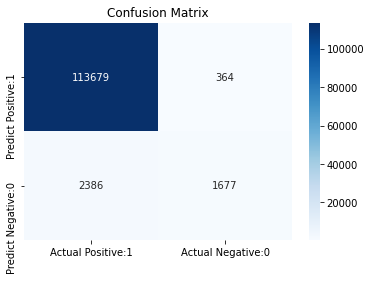

In [ ]:
# XGB with Early stopping

xgb = XGBClassifier(**best_params, tree_method='gpu_hist', reg_alpha=0.5)

evaluation_set = [(test_X, test_y)]

xgb.fit(X, y, early_stopping_rounds=200, eval_metric="auc", eval_set=evaluation_set, verbose=100)

# Predict on test data
y_pred = xgb.predict(test_X)

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_y, y_pred)

# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative:0','Actual Positive:1'], 
                                 index=['Predict Negative:0', 'Predict Positive:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues').set(title='Confusion Matrix')

In [ ]:
# create the predicted class
y_pred = xgb.fit(X, y).predict_proba(test_X)[:,1]

In [ ]:
# Matthews Correlation Coefficient
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(test_y, y_pred) 

0.5727965423725737

In [ ]:
# Change in FP and TP comared to baseline
DeltaFP = (364 - 2387)
DeltaTP = (1677 - 1842)
print("Delta change in FP:", DeltaFP)
print("Delta change in TP:", DeltaTP)

Delta change in FP: -2023
Delta change in TP: -165


In [ ]:
FPR = (364/(113679+364))*100
TPR = (1677/(2386+1677))*100
print('True positive rate:', TPR),
print('False positive rate:', FPR)


True positive rate: 41.27492000984494
False positive rate: 0.3191778539673632


In [ ]:
# Calculate the AUC
roc_auc_score(test_y, y_pred)

0.9223327054491834

In [ ]:
# Calculate the partial AUC (pAUC) 
roc_auc_score(test_y, y_pred, max_fpr= 0.0035)

0.6568320445233518

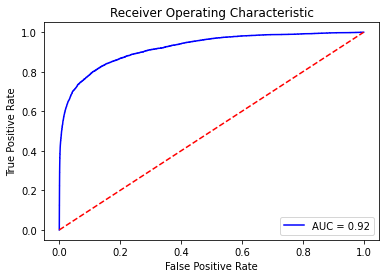

In [ ]:
# Build the ROC curve
buildROC(test_y, y_pred)

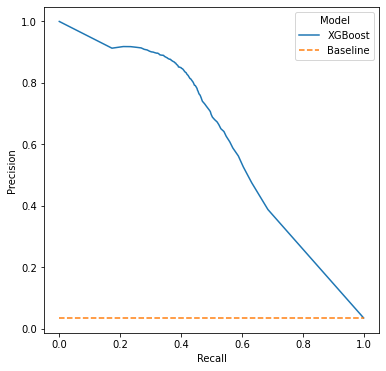

In [ ]:
# XGB

# Containers for true positive / false positive rates
xgb_precision_scores = []
xgb_recall_scores = []

xgb= XGBClassifier(**best_params, tree_method='gpu_hist')

y_test_probs = xgb.fit(X, y).predict_proba(test_X)[:,1]

# Define probability thresholds to use, between 0 and 1
probability_thresholds = np.linspace(0,1,num=100)

# Find true positive / false positive rate for each threshold
for p in probability_thresholds:
    
    y_test_preds = []
    
    for prob in y_test_probs:
        if prob > p:
            y_test_preds.append(1)
        else:
            y_test_preds.append(0)
            
    precision, recall = calc_precision_recall(test_y, y_test_preds)
        
    xgb_precision_scores.append(precision)
    xgb_recall_scores.append(recall)

# Plot precision-recall curve

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(xgb_recall_scores, xgb_precision_scores, label='XGBoost')
baseline = len(test_y[test_y==1]) / len(test_y)
ax.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc=1, title= "Model");

##### Features importance

In [ ]:
# Weight importance
feature_importance = xgb.get_booster().get_score(importance_type= "weight")
feature_importance_weight = pd.DataFrame(list(feature_importance.items()))
feature_importance_weight.columns = ['Feature', 'Importance']

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by="Importance", ascending=False)[:10].index
    best_features = feature_importance_df_[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by="Importance", ascending=False)[:10]
    best_features.reset_index(inplace=True)
    print(best_features.dtypes)
    plt.figure(figsize=(9, 5))
    sns.barplot(x="Importance", y="Feature", data=best_features)
    plt.title('XGBoost top 10 features')
    plt.tight_layout()

Feature       object
Importance     int64
dtype: object


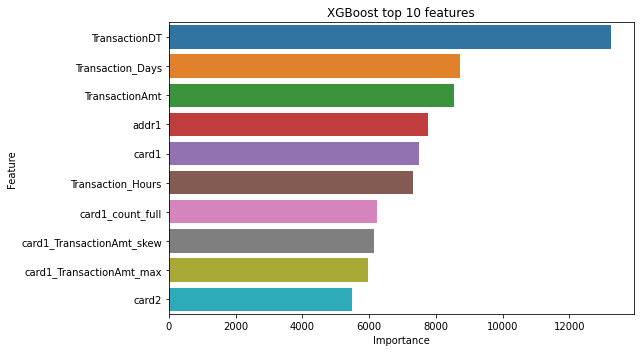

In [ ]:
display_importances(feature_importance_weight)